<h1> <center><span style="color:green"> Was 2018 an Exceptional Year for Louisville's Rainfall? </span></center> <h1>

2018 was a record year for Louisville with over 66 inches of rainfall. Was this record year statistically exceptional?

We will analyze all recorded rainfall (1872-present) for Louisville, KY ([source](https://w2.weather.gov/climate/xmacis.php?wfo=lmk)) that is stored in CSV format with this project.

In the first few cells, we will do all of the set up needed to import the Louisville Rain CSV and perform our analysis.

In [1]:
# Import all dependecies needed.

import os
import csv
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics
import scipy.stats

plt.figure(figsize = (15,10))
plt.style.use('classic')

In [2]:
# Get the current working directory via os.getcwd() so that it is relative and assign it to the directory variable.

directory = os.getcwd()
print(directory)

C:\Users\rcsall11\LouisvilleRain


In [3]:
# Since the rainfall data is stored in the \RainSourceData subdirectory we will add it to the directory variable.

directory += "\RainSourceData"
print(directory)

C:\Users\rcsall11\LouisvilleRain\RainSourceData


In [4]:
# The rainfalldata is stored in "louisville_rain_data.csv" and we will assign the directory variable plus the name of the CSV 
# to a new variable, filename.

filename = directory + "\louisville_rain_data.csv"
print(filename)

C:\Users\rcsall11\LouisvilleRain\RainSourceData\louisville_rain_data.csv


In [5]:
# Now the rainfall data, in CSV format, can be read using read_csv() from pandas and converted to a dataframe, df_louisville

df_louisville = pd.read_csv(filename)
df_louisville.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35
1,1873,2.93,5.42,3.39,3.05,5.73,2.84,3.43,3.04,2.47,3.26,2.19,6.99
2,1874,2.39,5.18,6.63,6.01,1.14,2.95,2.83,3.23,0.62,2.04,5.90,4.77
3,1875,2.42,2.09,4.54,0.98,4.07,5.79,16.46,2.19,1.05,1.92,6.14,5.67
4,1876,11.63,2.92,6.01,4.5,1,6.52,3.61,4.29,2.66,7.61,1.63,1.24


In [6]:
# Convert df_louisville to a sql table and establish a connection.

df_louisville.to_sql("louisville_rain_table", sqlite3.connect("louisville_rain.db"), if_exists = "replace")
db_lou = sqlite3.connect("louisville_rain.db")

With our CSV converted to a dataframe and then converted to a sql table. In the representation of the dataframe two cells above, there is not a column that shows the total rainfall. Below, a sql query is executed on the louisville_rain_table to get the sum of all of the month columns and create a new column "Total" displaying the results of SUM function. Afterwards, the table is converted to a pandas dataframe, and the index of the dataframe is set to the Year column to make any further lookups of data easier for our coming analysis.

In [7]:
lou_sum_query ="""
                SELECT Year, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, SUM(Jan + Feb + Mar + Apr + May + Jun + Jul + Aug + Sep + Nov + Dec)  AS Total
                FROM louisville_rain_table
                GROUP BY Year
                """

df_louisville = pd.read_sql_query(lou_sum_query, db_lou)
df_louisville.set_index('Year', inplace = True)
df_louisville.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35,9.74
1873,2.93,5.42,3.39,3.05,5.73,2.84,3.43,3.04,2.47,3.26,2.19,6.99,41.48
1874,2.39,5.18,6.63,6.01,1.14,2.95,2.83,3.23,0.62,2.04,5.90,4.77,41.65
1875,2.42,2.09,4.54,0.98,4.07,5.79,16.46,2.19,1.05,1.92,6.14,5.67,51.40
1876,11.63,2.92,6.01,4.5,1,6.52,3.61,4.29,2.66,7.61,1.63,1.24,46.01


With our query exceuted and table converted back to a dataframe, there is at least one year, 1872 with "M" with amount of rainfall for that respective month. We will see if there are any other years that have months with missing rainfall data as these non-numeric values do not contribute to the total rainfall for the year. Instead of backfilling the months missing data, we will remove those rows so that years with incomplete data do not decrease the mean such as with 1872's 9.72in of total recorded rainfall. 

In [8]:
#Find all instances of "M"
df_louisville[df_louisville.eq("M").any(1)]

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,M,M,M,M,M,M,M,2.45,4.38,3.92,0.56,2.35,9.74
1946,M,6.17,4.9,2.39,5.11,4.75,3.11,4.26,1.34,2.16,4.33,2.94,39.30


Since these "M"s are non-numeric and were not used to calculate total amount of rainfall for both 1872, we will check to see if they affect the datatype of each column since columns with non-numeric type would result in an error when calculating a sum or finding a maximum value. As well, we will soon need to decide what to do with these two years that have missing rainfall data.

In [9]:
# Check datatype of each column in the dataframe.
df_louisville.dtypes

Jan       object
Feb       object
Mar       object
Apr       object
May       object
Jun       object
Jul       object
Aug      float64
Sep      float64
Oct      float64
Nov      float64
Dec      float64
Total    float64
dtype: object

With Jan-Jul columns being objects, we will not be able to perform any mathmathical operations or even certain pandas methods on them. We will need to convert them to a numerical type. With the pd.to_numeric() method, all of the columns can be converted to a numeric datatype. In addition, this function can also convert any errors, such as those that will occur when it tries to parse "M", to NaN(Not a Number); this will be useful when deciding what to do with the data from 1872 and 1946.

In [10]:
#Cast all object columns to numeric datatype and cast all columns to float32 as the precision with float64 is not necessary.
df_louisville = df_louisville.apply(pd.to_numeric, downcast ="float", errors="coerce")
#Check data types to confirm.
df_louisville.dtypes

Jan      float32
Feb      float32
Mar      float32
Apr      float32
May      float32
Jun      float32
Jul      float32
Aug      float32
Sep      float32
Oct      float32
Nov      float32
Dec      float32
Total    float32
dtype: object

In [11]:
#Display the head of the table to confirm "M" was converted to NaN
df_louisville.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.45,4.38,3.92,0.56,2.35,9.740000
1873,2.93,5.42,3.39,3.05,5.73,2.84,3.430000,3.04,2.47,3.26,2.19,6.99,41.480000
1874,2.39,5.18,6.63,6.01,1.14,2.95,2.830000,3.23,0.62,2.04,5.90,4.77,41.650002
1875,2.42,2.09,4.54,0.98,4.07,5.79,16.459999,2.19,1.05,1.92,6.14,5.67,51.400002
1876,11.63,2.92,6.01,4.50,1.00,6.52,3.610000,4.29,2.66,7.61,1.63,1.24,46.009998


We proceed with cleaning up the data. With both 1872 and 1946 missing monthly rainfall totals, we will omit all of 1872's and 1946's data since keeping this data would skew the mean of the yearly rainfall lower and could possibly cause the 2018 total rainfall appear more extreme than it really is. There will still be enough data to answer the question of 2018 being an extreme year in rainfall. To omit 1872 and 1946's rows from the dataframe, the pd.dropna() method will be used as it will find any instances of a NaN and drop the row or column where this occurs(in this case, rows.) In addition, we will obtain the sum of all columns as we can compare 2018's total rainfall against the mean total rainfall.

In [12]:
#Drop columns
df_louisville.dropna(axis = 'rows', how ='any', inplace = True)
#Get the mean of all of the columns
df_louisville.loc['Mean'] = df_louisville.mean(axis =0)
#Display the tail which will include the mean yearly rainfall and the total rainfall for 2018.
df_louisville.tail()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Total
Year,,,,,,,,,,,,,
2015,0.870000,2.230000,7.800000,10.840000,2.380000,6.820000,8.650000,3.470000,2.450000,4.850000,5.470,6.580000,57.560001
2016,1.010000,4.810000,5.500000,3.180000,4.560000,4.250000,4.650000,5.710000,2.280000,0.650000,1.650,5.300000,42.900002
2017,4.210000,2.060000,3.680000,4.470000,4.740000,3.260000,2.790000,4.200000,5.470000,4.890000,2.060,2.730000,39.669998
2018,1.760000,10.540000,5.050000,3.400000,4.980000,6.380000,5.130000,7.230000,10.910000,2.790000,4.760,5.900000,66.040001
Mean,3.723724,3.371448,4.574482,4.129103,4.264689,3.930138,3.910344,3.359104,2.997242,2.826552,3.522,3.764207,41.546482


Now that the data has been cleaned up, we can move to our analysis to determine if Louisville's 2018 rainfall was extreme. To answer this question, several different methods will be used to determine if 2018's rainfall is truely an outlier. Firstly, let's graphically look at 2018's total rainfall against the average rainfall. This will be plotted to a column chart.

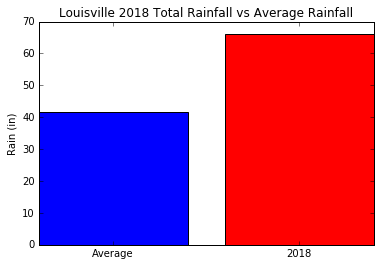

In [13]:
#Assign the 2018's total rainfall and the average yearly rainfall to variables 
#to be used in a column graph and other calculations
louisvilleTotalRainFall2018 = df_louisville.loc[2018, 'Total']
louisvilleTotalRainFallMean = df_louisville.loc['Mean', 'Total']


#Plot the average  rainfall against the 2018 rainfall
objects = ("Average", "2018")
color = ["blue", "red"]
plt.bar(objects,[louisvilleTotalRainFallMean, louisvilleTotalRainFall2018], color = color, align = "center")
plt.title("Louisville 2018 Total Rainfall vs Average Rainfall")
plt.ylabel("Rain (in)")
plt.show()

Graphically, Louisville's rainfall appears significantly greater than the average rainfall in Louisville. We can determine the difference from the mean for a concrete value by subtracting the mean from the total rainfall for 2018.

In [14]:
louisville2018RainFallDifference = (louisvilleTotalRainFall2018 - louisvilleTotalRainFallMean)
louisville2018RainFallDifference

24.493519

The total rainfall for Louisville in 2018 was 24.49 inches above average. This certainly sounds very large, but we can graphically compare 2018's against all other years to get a better idea if there are a large number of similar years.

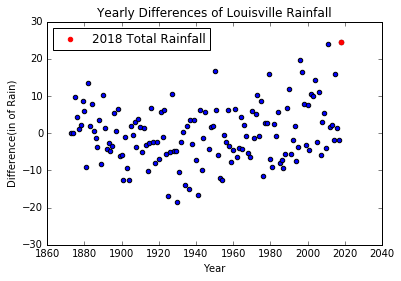

In [15]:
#Assign the 'Total' column to a variable and exclude the final value, the mean total rainfall.
louisvilleTotalRainFallSeries = (df_louisville['Total'][0:-1])
years = []
differences = []
#Loop through a slice louisvilleTotalRainfallSeries to exclude the mean and add each year to its the years list,  
# calculate the difference from the meanm and add the difference its list.
for i, r in louisvilleTotalRainFallSeries.items():
    years.append(i)
    differences.append(r-louisvilleTotalRainFallMean)
    

#Plot the differences    
plt.scatter(years, differences)
#Highlight the 2018 difference by plotting it to the scatterplot in red.
plt.scatter(years[-1], differences[-1], color = "red", label="2018 Total Rainfall")
plt.legend(scatterpoints =1, loc='best')
plt.xlabel("Year")
plt.ylabel("Difference(in of Rain)")
plt.title("Yearly Differences of Louisville Rainfall")
plt.show()

In the plot above, 2018's rainfall, indicated in red, is the has the greatest difference from the mean. However, this is already a known since 2018 has the greatest amount of recorded total rainfall. As well, there is another year that had nearly as much rainfall as 2018. Since there is another datapoint that lies near 2018's total rainfall amount, it is totally possible that 2018 is not as exceptional as it seems. To determine if 2018 was truely an extreme or exceptional year, we will check to see if 2018 is a statisical outlier with the following 2 basic methods: [Tukey's Fences](https://en.wikipedia.org/wiki/Outlier#Tukey's_fences), and [Z-score](https://www.ctspedia.org/do/view/CTSpedia/OutLier).

Firstly, we will plot a box plot, since a boxplot uses Tukey's Fences to indicate outliers, as well as 2018's total rainfall to check if 2018's total rainfall is a statistical outlier. 

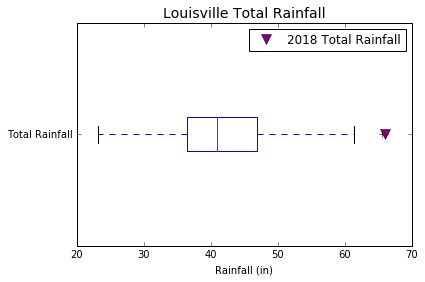

In [16]:
#Boxplot
plt.boxplot(louisvilleTotalRainFallSeries, vert = False)
#Plot 2018's total rainfall on the boxplot
plt.plot(louisvilleTotalRainFall2018, 1,  marker = 'v', c='purple', markersize = 10,linestyle='none',
         label="2018 Total Rainfall")
plt.title("Louisville Total Rainfall", fontsize = 14)
plt.yticks([1], ["Total Rainfall"])
plt.xlabel("Rainfall (in)", fontsize = 10)
plt.legend(numpoints=1, loc='best')
plt.show()

On the boxplot, it indicates that 2018's total rainfall is an outlier indicated by the inverted purple triangle. In the cell below, the calculation for Tukey's Fences is displayed and tested for 2018's total rainfall. A result of "True" indicates that this value is an outlier. 

In [17]:
#Obtain values for the 25th quartile and 75th quartile
q75Lou,  q25Lou = np.percentile(louisvilleTotalRainFallSeries, [75, 25])
#Calculate interquartile range
iqrLouisville = q75Lou - q25Lou
#Test if 2018 total rainfall is greater than the 75th quartile plus 1.5 times the interquartile range
louisvilleTotalRainFall2018 > (q75Lou + 1.5*iqrLouisville)

True

Another way to determine an outlier is to calculate the Z-score. If the Z-score for a data point is >3 or <-3 (it can be argued that this is an arbitrary number), then it is an outlier.

In [18]:
#Get standard deviation
louMeanStdDev = statistics.stdev(louisvilleTotalRainFallSeries)
#Divide the difference from the mean for 2018 total rainfall by the standard deviation
zScoreLou=louisville2018RainFallDifference/louMeanStdDev
print(zScoreLou)

3.1035029355408086


Since the Z-score is greater than 3, 2018's total rainfall is identified as an outlier by a second method. 

As well, the Z-score can be used to calculate the probability([p-value](https://en.wikipedia.org/wiki/P-value)) that a value greater than the datapoint would occur. Multiplying the p-value by 100 will result in an percentage.

In [19]:
#Calulate p-value
p_value = 1 - scipy.special.ndtr(zScoreLou)
#Multply by 100 to obtain a percentage
print(p_value * 100, p_value)

0.09562216883818309 0.0009562216883818309


The probabilty for a year to exceed 2018's total rainfall is only 0.09%(9 out of 10,000 years). This certainly reinforces that 2018's record rainfall would be an extremely rare event based on history. This probability can be visually represented with a [bell curve/Gaussian Curve](https://www.investopedia.com/terms/b/bell-curve.asp)/[normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) and the area under the curve to the left or right. Since we are looking for a value greater than 2018's total rainfall, the area we are looking for would be to the right. With the probability being so small, we will plot 2018's total rainfall as a point along with the area since the area would be difficult to see on most any display device. As well, we can informallly test how 'normal' the distribution of the rainfall data is ([normality test](https://en.wikipedia.org/wiki/Normality_test)) by compariing it against the bell curve.

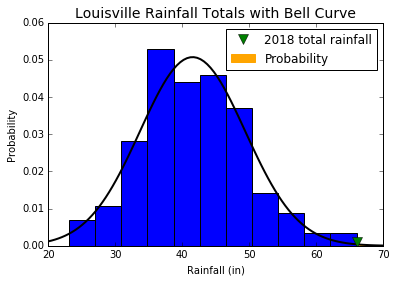

In [20]:
#Histogram
plt.hist(louisvilleTotalRainFallSeries, bins='auto', density = 'True')
plt.title("Louisville Rainfall Totals with Bell Curve", fontsize = 14)
plt.xlabel("Rainfall (in)", fontsize = 10)
plt.ylabel("Probability", fontsize = 10)

#Plot Probability Density Function
mu, std = scipy.stats.norm.fit(louisvilleTotalRainFallSeries)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#Shade in area of probability with more total rainfall than 2018
plt.fill_between(x, 0, p, where=(x >= louisvilleTotalRainFall2018), color = 'orange', label='Probability')
#Plot 2018 as a point since the value will be so small
plt.plot(louisvilleTotalRainFall2018, p_value, marker = 'v', color='green', markersize = 10, linestyle='none', label='2018 total rainfall')
plt.legend(numpoints=1,loc='best')

plt.show()

As indicated by the green triangle, the probabilty of a year having more rainfall than 2018 is extremely small. Additionally, the distribution is fairly normal, but not perfectly normal. With distribution being fairly normal, we can be fairly confident in the analysis that we have done as probability is best calculated from normal distributions.

<h2><center>Conclusion</center></h2>
    
In conclusion, 2018's rainfall is a statistical outlier and thusly extreme as it is more than 3 standard deviations above the mean, and it's p-value is 0.0009562216883818309.